# Building a Contemporary Music Recommendation System

Our goal is to create a modern song recommendation given an older song provided by the user. In order to accomplish this goal, we aim to create two models. The first model is a similarity model, which will output new songs that have similar song features to the given song, such as danceability, energy, and acousticness. We will be using the k-nearest neighbors model to achieve this. As any good decision-making model does, it will explain to the user the specific song features of their chosen query. It will also explain the similarities between the older song and the newer, provided songs. 

Our next model will be based upon relative music trends over time. Trends in tempo, energy, and acousticness have changed drastically throughout the decades. Although this may not be exactly what the user envisioned when matching their song, we are aiming to create music recommendations based upon decades. Thus, this second model will find how the user's query relates to song trends within that decade, and extrapolate a similar song compared to trends within the current decade. Maybe the user can listen to new music, up to date with the trends! This model will also explain the reasoning behind the choices, communicating how the song compares to typical songs within its time.


## Kaggle Dataset

We first begin by importing the necessary libraries, and the dataset of songs we will be using for this project. The dataset is retrieved from https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020. It contains a dataset of 169k Spotify songs from 1921-2020, containing tracks from artists with 1 million+ listeners on Spotify. It was created using the Spotify Web API. 

We originally tried to utilize data from a 600k dataset of songs, but quickly realized that songs across cultures do not translate effectively. This dataset had songs from all languages, with no way to understand which song was English or not. When the user gives an English song to match, we wouldn't want to give them an Dutch song in return! Thus, we modified our dataset to have relevant songs in English, and the user will be able to choose from this set.

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


songs_data = pd.read_csv("data.csv")

songs_data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563000,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901000,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887000,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908000,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.1530,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.7610,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,-2.557,1,I Found You,70,2020-02-28,0.0385,129.916,0.4720,2020


In [208]:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

Now, we can see the different features of a song in the dataset. Each song has quantitative values for qualitative features - such as danceability and acousticness! We can use this to our advantage when recommending a song for the user. 

Next, we remove null values and duplicates from our dataset.

In [209]:
songs_data.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [210]:
songs_data = songs_data.dropna()
songs_data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563000,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901000,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887000,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908000,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.1530,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.7610,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,-2.557,1,I Found You,70,2020-02-28,0.0385,129.916,0.4720,2020


There may be duplicate songs from different album release versions, and they have different IDs. For instance, there are two songs of Harry Styles' "Adore You." Thus, we remove duplicates based solely upon name of the song and the artist.

In [211]:
songs_data[songs_data['name'] == 'Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,0.569,2019
87883,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,8,0.102,-3.675,1,Adore You,86,2019-12-06,0.0483,99.048,0.569,2019
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,-5.407,1,Adore You,70,2013-10-04,0.0315,119.759,0.201,2013


In [212]:
songs_data = songs_data.drop_duplicates(subset = ['name', 'artists'])
songs_data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563000,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901000,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887000,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908000,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,"['LEGADO 7', 'Junior H']",0.795,218501,0.5850,0,52Cpyvd2dKb6XRn313nH87,0.000001,8,0.1120,-4.451,1,Ojos De Maniaco,68,2020-02-28,0.0374,97.479,0.9340,2020
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.1530,2020


In [213]:
songs_data[songs_data['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,0.569,2019
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,-5.407,1,Adore You,70,2013-10-04,0.0315,119.759,0.201,2013


## Exploratory Data Analysis

Next, we attempt to analyze our dataset. Since we are hoping to create a contemporary song recommendation system, it would be useful to understand changes in music trends over time. We also group the songs by decade.

In [214]:
songs_data.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,156608.000000,156608.000000,1.566080e+05,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000
mean,0.495783,0.537458,2.310463e+05,0.487088,0.086905,0.163163,5.200967,0.207698,-11.393035,0.707505,31.156588,0.096316,116.896800,0.531012,1977.204511
std,0.376842,0.175659,1.221553e+05,0.267400,0.281697,0.309991,3.515506,0.177673,5.665935,0.454910,21.513933,0.154385,30.790044,0.262406,25.671797
min,0.000000,0.000000,5.991000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.095700,0.416000,1.706400e+05,0.262000,0.000000,0.000000,2.000000,0.098700,-14.514000,0.000000,12.000000,0.035000,93.363750,0.321000,1956.000000
50%,0.499000,0.547000,2.080405e+05,0.478000,0.000000,0.000214,5.000000,0.136000,-10.499000,1.000000,33.000000,0.045300,114.765500,0.543000,1978.000000
75%,0.890000,0.667000,2.625330e+05,0.708000,0.000000,0.092125,8.000000,0.264000,-7.132750,1.000000,48.000000,0.076800,135.750250,0.748000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,97.000000,0.969000,244.091000,1.000000,2020.000000


Here, we are taking the release date, which is in the format yyyy-mm-dd and converting it into an integer of just the year. This way, it is easier to group the songs by decade. 

In [215]:
type(songs_data['release_date'][0])


str

In [216]:
#standardize release-date strings (some which have year-month-date, and some with year) with just the year

songs_data.release_date.replace({'-.*': ''}, regex=True, inplace=True)

/var/folders/3d/ktsrmxpd10sgvt5jrfgqcwv40000gq/T/ipykernel_42725/2756862938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_data.release_date.replace({'-.*': ''}, regex=True, inplace=True)


In [217]:
print(songs_data['release_date'])

0         1928
1         1928
2         1928
3         1928
4         1928
          ... 
169903    2020
169904    2020
169905    2020
169906    2020
169907    2020
Name: release_date, Length: 156608, dtype: object


In [218]:
songs_data['release_date'] = songs_data['release_date'].astype(int)
songs_data = songs_data.sort_values(by='release_date')

songs_data[songs_data['name']=='Adore You']


/var/folders/3d/ktsrmxpd10sgvt5jrfgqcwv40000gq/T/ipykernel_42725/3018967004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_data['release_date'] = songs_data['release_date'].astype(int)


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,-5.407,1,Adore You,70,2013,0.0315,119.759,0.201,2013
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019,0.0483,99.048,0.569,2019


Next, we will observe how many songs there are for each decade, within this specific database. We will also observe trends within the song feature over time. This will be useful information when thinking about how to give the user a contemporary song.

<Axes: xlabel='decade', ylabel='count'>

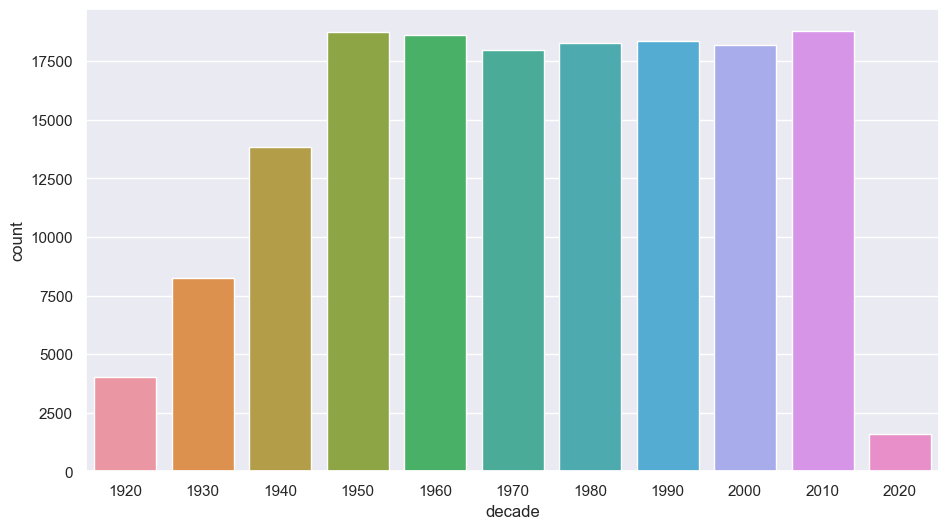

In [219]:
def get_decade(year):
    decade = int(year/10) * 10
    return decade

songs_data['decade'] = songs_data['release_date'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(x = 'decade', data = songs_data)

<Axes: xlabel='release_date', ylabel='tempo'>

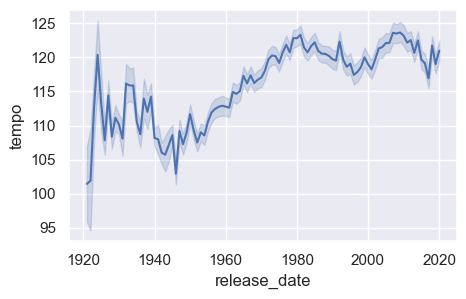

In [220]:
sns.set(rc={'figure.figsize':(5 ,3)})
sns.lineplot(x = "release_date", y = "tempo", data = songs_data)

<Axes: xlabel='release_date', ylabel='acousticness'>

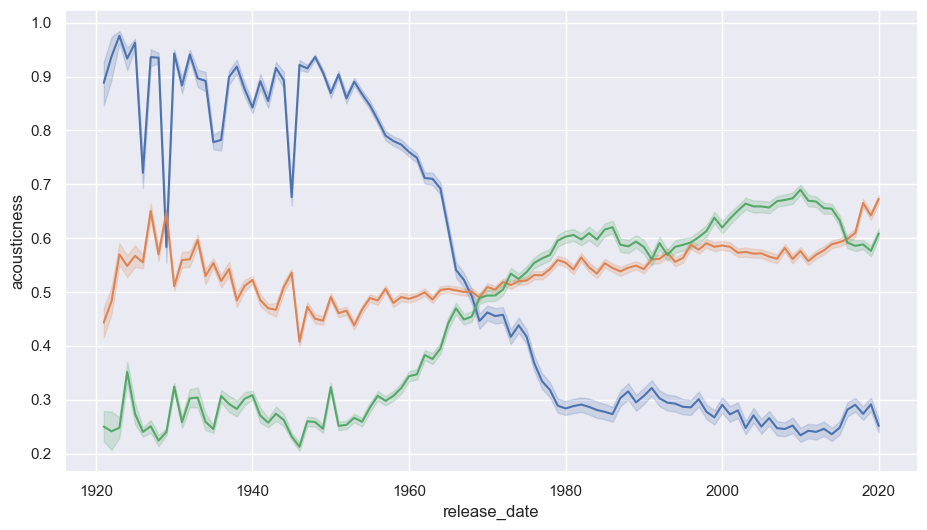

In [221]:
new_songsdf = songs_data.sample(n = 1000)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.lineplot(x = "release_date", y = "acousticness", data = songs_data)
sns.lineplot(x = "release_date", y = "danceability", data = songs_data)
sns.lineplot(x = "release_date", y = "energy", data = songs_data)

## Model 1: Similar Songs using K-Nearest Neighbors

The k-nearest neighbors (k-NN) algorithm finds similar elements given a certain query point, perfect for our usage! 

The k-nearest neighbors algorithm, in this case, utilizes Euclidean distance. We are take the query song, and are calculating the distance to every song in the modern decade dataset. The "distance" between songs is calculated using the Euclidean distance formula:

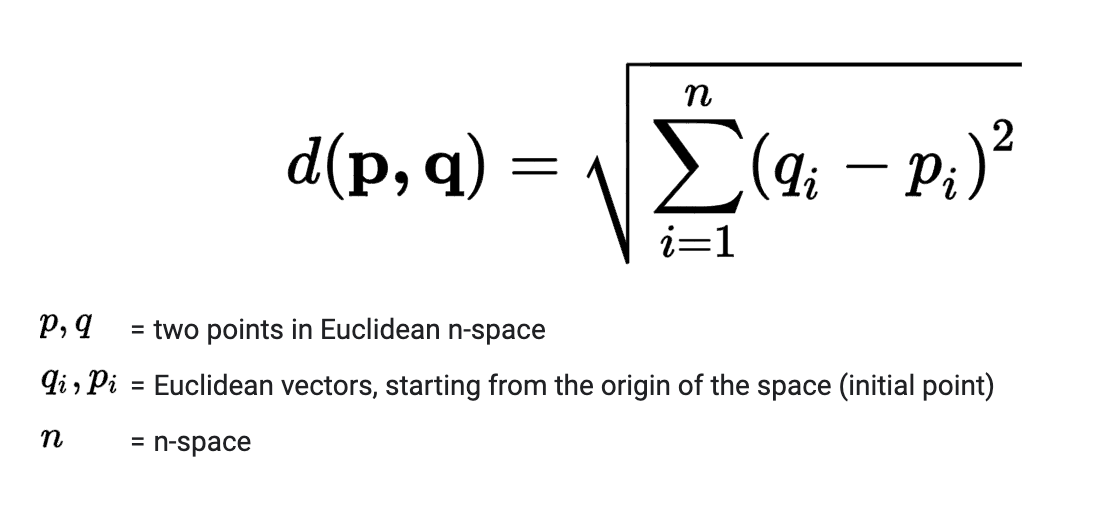

We combine the distances between every song feature using this formula, to come up with a final "distance" between songs. The k-NN algorithm outputs the k closest songs, k value being the number of similar songs that the user requests.

We will only query with songs from after 2010, as we are trying to give the user modern songs. The query point for this algorithm will be the song that the user inputs. 

In [222]:
df = songs_data[songs_data['release_date'] > 2010]
df

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,decade
69754,0.00055,['Icon For Hire'],0.570,185080,0.904,0,4nPI6aIrHaMNZbF2q8NfpX,0.000000,5,0.3790,-4.377,0,Off With Her Head,47,2011,0.0746,92.948,0.840,2011,2010
96890,0.00115,['Seether'],0.630,229720,0.860,0,2abHKI9Oox4NBEhOh3HMbq,0.000001,0,0.2310,-6.117,1,Country Song,63,2011,0.0327,95.978,0.911,2011,2010
69751,0.03340,"['Snoop Dogg', 'Wiz Khalifa']",0.569,228733,0.691,1,2OmfRyHIFAkMEEwmbgz7lN,0.000000,1,0.1530,-6.462,0,That Good,49,2011,0.3180,180.056,0.189,2011,2010
96919,0.00285,['Tech N9ne'],0.746,326427,0.853,1,2Lo2BWhhlZSJds2yBhxoet,0.000000,1,0.3760,-4.452,1,Worldwide Choppers,60,2011,0.1300,130.028,0.362,2011,2010
69752,0.03950,['Radiohead'],0.693,319249,0.776,0,2rA36OZNb3LkvqcNro1ugK,0.737000,3,0.0884,-9.804,1,Separator,49,2011,0.0560,113.808,0.659,2011,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161409,0.03490,"['Kygo', 'Sandro Cavazza']",0.614,217766,0.709,0,745bEQatiiXDtBe1AdQY2P,0.000000,11,0.0904,-5.742,0,Beautiful,72,2020,0.0428,123.843,0.269,2020,2020
161410,0.00345,"['Elevation Worship', 'Brandon Lake']",0.286,452499,0.769,0,0pNizrRmvu5S16fH6ccm0v,0.000000,11,0.9110,-6.353,1,Graves Into Gardens (Live) (feat. Brandon Lake),67,2020,0.0539,139.442,0.128,2020,2020
161411,0.23800,"['Anuel AA', 'Farruko', 'Zion']",0.624,226160,0.888,1,5p3JJehpKHjr9pJT5eD2Lz,0.000000,2,0.3170,-2.130,1,Que Se Joda,75,2020,0.0990,180.088,0.824,2020,2020
161402,0.17600,['YoungBoy Never Broke Again'],0.738,145851,0.678,1,485RHcQUM5qotAlfutUhwT,0.000000,11,0.2500,-6.596,0,Ain't Easy,65,2020,0.1340,79.002,0.514,2020,2020


In [223]:
# Computes the distance from every song in the dataframe to the query song
# Uses the given columns as metrics for Euclidean distance

def queryCols(queryID, query_idx, songsData, columns, k):
    
    new_songs = songsData[columns].copy(deep=True)
    
    new_songs['dist'] = new_songs.apply(lambda x: np.linalg.norm(x-query_idx), axis=1)
    new_songs = new_songs.sort_values('dist')
    new_songs.drop_duplicates()
    
    return new_songs.head(k)


In [224]:
# Given the ID of a song, finds the index within the larger dataset
def findSongIdx(queryID, df):
    tmp = df.copy(deep=True)
    query_idx = (tmp.index[(tmp['id'] == queryID)].tolist())
    if(query_idx):
        return query_idx[0]
    
    return query_idx


# Given many indices of songs, returns song names and IDs
# Used for easier output of similar songs
def songNames(df, song_arr):
    song_ids = []
    song_names = []
    
    for idx in song_arr:
        df_row = df.loc[[idx]]
        song_names.append((df_row['name'], df_row['artists']))
        song_ids.append(df.at[idx,'id'])
        
    return song_names, song_ids

# Given a song ID, and the number of desired similar songs, outputs new songs based upon kNN algorithm
# Compiles the above functions
def querykNN(song_ID, k):
    columns = ['instrumentalness', 'energy', 'key','danceability','liveness','loudness', 'speechiness','valence', 'popularity']
    
    idx = findSongIdx(song_ID, songs_data)
    
    querySong = songs_data[columns].loc[idx]
    
    new_recs = queryCols(song_ID, querySong, df, columns, k)
    
    songs_names, song_ids = songNames(df, new_recs.index.values)
    
    return new_recs, songs_names, song_ids
    
    

We previously looked at various instances of "Adore You." Let's test out the k-nearest neighbors algorithm with Miley Cyrus's "Adore You," released in 2013. We will ask for the 10 most similar songs.

In [225]:
new_recs, new_names, new_ids = querykNN('5AnCLGg35ziFOloEnXK4uu', 10)
print(new_names)

[(97046    Adore You
Name: name, dtype: object, 97046    ['Miley Cyrus']
Name: artists, dtype: object), (32185    About Love - From The Netflix Film “To All The...
Name: name, dtype: object, 32185    ['MARINA']
Name: artists, dtype: object), (169532    Chained To The Rhythm
Name: name, dtype: object, 169532    ['Katy Perry', 'Skip Marley']
Name: artists, dtype: object), (135323    Teenager in Love
Name: name, dtype: object, 135323    ['Madison Beer']
Name: artists, dtype: object), (87364    I Like The Sound Of That
Name: name, dtype: object, 87364    ['Rascal Flatts']
Name: artists, dtype: object), (8139    La Estoy Pasando Mal
Name: name, dtype: object, 8139    ['Grupo Firme']
Name: artists, dtype: object), (161301    VOICES (feat. XXXTENTACION)
Name: name, dtype: object, 161301    ['Skye', 'XXXTENTACION']
Name: artists, dtype: object), (126107    BIG
Name: name, dtype: object, 126107    ['Young M.A']
Name: artists, dtype: object), (87073    Keep Your Head Up
Name: name, dtype: object

However, this is not that pretty. We can find a better way to print the new song names. Let's make a way to print these in a readable way for the user.

In [226]:
def print_songs(df, song_arr, k):
    
    print(f"Here are your {k} new songs:")
    
    for idx in song_arr:
        df_row = df.loc[[idx]]
        
        print(f"    - {df_row['name'].item()} by {(df_row['artists'].item()).strip('[]')}")
        

In [227]:
print_songs(df, new_recs.index.values, 10)

Here are your 10 new songs:
    - Adore You by 'Miley Cyrus'
    - About Love - From The Netflix Film “To All The Boys: P.S. I Still Love You” by 'MARINA'
    - Chained To The Rhythm by 'Katy Perry', 'Skip Marley'
    - Teenager in Love by 'Madison Beer'
    - I Like The Sound Of That by 'Rascal Flatts'
    - La Estoy Pasando Mal by 'Grupo Firme'
    - VOICES (feat. XXXTENTACION) by 'Skye', 'XXXTENTACION'
    - BIG by 'Young M.A'
    - Keep Your Head Up by 'Andy Grammer'
    - 100 Degrees by 'Rich Brian'


Now we can read the outputted songs easily. We will continue exploring the model.

Let's test this with a song from long ago, which is what this program is meant for. This is "Nocturne in E-flat major" by Frederic Chopin. It was composed in 1830-1832. This is a very popular arrangement on the piano; you may have heard it before!

In [228]:
new_recs, new_names, new_ids = querykNN('6xpA90VSHtmaUhNltHIcVM', 10)
print_songs(df, new_recs.index.values, 10)

Here are your 10 new songs:
    - Liability by 'Lorde'
    - I Know You Care by 'Ellie Goulding'
    - Reality Check by 'Swae Lee'
    - Everybody's Gotta Learn Sometime by 'G-Eazy'
    - Orgelbüchlein - Arr. For Piano Four Hands by György Kurtág: Nun komm’ der Heiden Heiland, BWV 599 by 'Johann Sebastian Bach', 'Lucas Jussen', 'Arthur Jussen'
    - Losing - Joe Goddard Remix by 'Becky Hill'
    - Girls Need Love by 'Summer Walker'
    - Catalina by 'ROSALÍA'
    - You Don't Know Me - Radio Edit by 'Jax Jones', 'RAYE'
    - Abar Phire Ele by 'Arijit Singh'


The first song, "Liability" by Lorde, is very similar! It is a great modern representation of "Nocturne in E-flat major," as it has the unique slow start with haunting piano.


However, when trying out the songs that matched, we found some are quite similar, but others do not give the same level of energy as the query song. This led us to the conclusion that some song features might need to be weighted higher than other features. Thus, we modify our k-NN algorithm to include a higher weight for factors such as energy.


In [229]:
df2 = songs_data[songs_data['release_date'] > 2015]

def weightDistance(curr_row, query_idx):
    weightList = []
    weightList.append(np.linalg.norm(curr_row - query_idx))
    weightList.append(np.linalg.norm(curr_row['energy'] - query_idx['energy']))
    weightList.append(np.linalg.norm(curr_row['key'] - query_idx['key']))
    weight = np.mean(weightList)
    return weight
    

def distWeights(queryID, query_idx, songsData, columns, k):
    
    new_songs = songsData[columns].copy(deep=True)
    new_songs['dist'] = new_songs.apply(lambda x: weightDistance(x, query_idx), axis = 1)
    new_songs = new_songs.sort_values('dist')
    new_songs.drop_duplicates()
    
    return new_songs.head(k)

def queryWeight(song_ID, k):
    columns = ['instrumentalness', 'energy', 'key','danceability','liveness','loudness', 'speechiness','valence', 'popularity']
    
    idx = findSongIdx(song_ID, songs_data)
    
    querySong = songs_data[columns].loc[idx]
    
    new_recs = distWeights(song_ID, querySong, df, columns, k)
    
    songs_names, song_ids = songNames(df, new_recs.index.values)
    
    return new_recs, songs_names, song_ids

In [230]:
new_recs, new_names, new_ids = queryWeight('6xpA90VSHtmaUhNltHIcVM', 10)
print_songs(df, new_recs.index.values, 10)

Here are your 10 new songs:
    - Liability by 'Lorde'
    - I Know You Care by 'Ellie Goulding'
    - Reality Check by 'Swae Lee'
    - You Don't Know Me - Radio Edit by 'Jax Jones', 'RAYE'
    - Orgelbüchlein - Arr. For Piano Four Hands by György Kurtág: Nun komm’ der Heiden Heiland, BWV 599 by 'Johann Sebastian Bach', 'Lucas Jussen', 'Arthur Jussen'
    - Losing - Joe Goddard Remix by 'Becky Hill'
    - Lo Maan Liya (From "Raaz Reboot") by 'Arijit Singh'
    - Abar Phire Ele by 'Arijit Singh'
    - Everybody's Gotta Learn Sometime by 'G-Eazy'
    - Stay Awake by 'Dean Lewis'


This updated model still retrieves similar top songs, but we can see that the some songs towards the middle have changed. These now fit the mood and energy of the query song more; exactly what we want for a similar song!

Now we have a working model that outputs the ten most similar songs since 2010! In order to be a decision-making program, however, we need to explain to the user how we found their new playlist.


## Explanation of Similarity Song Choice (Model 1)

We will employ an English explanation generator, similar to that of the VOTE program, to explain the song choice. We begin by describing the song features compared to the averages for that particulate feature. 

For this, we will use quartile ranges as generated by the describe() function. We are only looking at the song features we used to calculate similarity within the k-NN algorithm.

In [231]:
columns = ['acousticness','danceability','energy','instrumentalness','liveness','loudness', 'speechiness','valence', 
          'tempo', 'popularity']
songs_avgs = songs_data[columns].describe()
songs_avgs

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,popularity
count,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000,156608.000000
mean,0.495783,0.537458,0.487088,0.163163,0.207698,-11.393035,0.096316,0.531012,116.896800,31.156588
std,0.376842,0.175659,0.267400,0.309991,0.177673,5.665935,0.154385,0.262406,30.790044,21.513933
min,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.095700,0.416000,0.262000,0.000000,0.098700,-14.514000,0.035000,0.321000,93.363750,12.000000
50%,0.499000,0.547000,0.478000,0.000214,0.136000,-10.499000,0.045300,0.543000,114.765500,33.000000
75%,0.890000,0.667000,0.708000,0.092125,0.264000,-7.132750,0.076800,0.748000,135.750250,48.000000
max,0.996000,0.988000,1.000000,1.000000,1.000000,3.855000,0.969000,1.000000,244.091000,97.000000


Let's continue with our example of Miley Cyrus's "Adore You." We can see the values of the song features below. 

In [232]:
songs_data.loc[[findSongIdx('5AnCLGg35ziFOloEnXK4uu', songs_data)]]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,decade
97046,0.111,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,-5.407,1,Adore You,70,2013,0.0315,119.759,0.201,2013,2010


We could describe this song as such: this song has a high danceability factor, and is very popular! However, it has a low instrumentalness. 

Following this method, will now try and convert these metrics into readable sentences for the user.

In [233]:
def describe_song(song_id):
    
    new_columns = ['danceability', 'instrumentalness','loudness', 'tempo', 'popularity']
    
    
    song_idx = findSongIdx(song_id, songs_data)
    curr_song = songs_data.loc[[song_idx]]
    very_low = songs_avgs.loc['min']
    low = songs_avgs.loc['25%']
    avg = songs_avgs.loc['50%']
    high = songs_avgs.loc['75%']
    very_high = songs_avgs.loc['max']
    
    result = ''
    
    
    for feature in new_columns:
        
        curr_val = songs_data.at[song_idx, feature]
        
        phrases = {
        "VERY_HIGH": [f"Wow! This song has incredible levels of {feature}.",
                      f"Wow! This song is very high in {feature}. Much higher than the average for songs."
                     ],
            
        "HIGH":[f"This song has high levels of {feature}.",
                f"This song is above average in terms of {feature}."
               ],
            
        "HIGH_D": [f"Your chosen song is very danceable, meaning, it is very high energy for its time!",
                    f"If I were living during this decade, I would certainly want to dance to your song! It is very high energy.",
                    f"Let's party! This song is very danceable and high in energy."
                   ],
            
        "LOW_D": [f"Energy-wise, this song is danceable, but nothing special. It is consistent with the average song energy and danceability."
                  f"Your chosen song is average in terms of energy. Maybe the mood is more calm and casual today!.",
                  f"This is a slower, more chill song. Not very high energy in terms of the average for songs!."
                  f"If I were going to a party during this decade, I don't think I would want this song playing. That is, this song is relatively low energy."
                  ],
        "AVG": [f"Your chosen song is just average in terms of {feature}.",
                f"In terms of {feature}, this song is quite average."
               ],
        "LOW": [f"This song is alright in terms of {feature}.",
                f"In terms of {feature}, this song is quite average."
               ],
        "VERY_LOW": [f"This song is very very low for {feature}.",
                     f"Unfortunately (or fortunately!) this song is quite low for {feature}."
                    ],
        "HIGH_POP": [f"Your chosen song is very popular, and highly played."],
        "LOW_POP": [f"Great music taste. Your chosen song is not as popular, and you might be looking for more underground songs."]
            
        }
        
        label = "AVG"
        
        if (feature == 'danceability'):
            
            if curr_val > avg[feature]:
                label = "HIGH_D"
            elif curr_val <= avg[feature]:
                label = "LOW_D"
                
        elif (feature == 'popularity'):
            
            if curr_val > avg[feature]:
                label = "HIGH_POP"
            elif curr_val <= avg[feature]:
                label = "LOW_POP"
        
        else:
            
            if curr_val > high[feature]:
                label = "VERY_HIGH"
                
            elif curr_val > avg[feature]:
                label = "HIGH"
                
            elif curr_val < avg[feature]:
                label = "LOW"
                
            elif curr_val < low[feature]:
                label = "VERY_LOW"
                

        result += random.choice(phrases[label]) + " "

    return result
            
            
    

In [234]:
songs_data.loc[[findSongIdx('5AnCLGg35ziFOloEnXK4uu', songs_data)]]

describe_song('5AnCLGg35ziFOloEnXK4uu')

"Let's party! This song is very danceable and high in energy. This song is alright in terms of instrumentalness. Wow! This song is very high in loudness. Much higher than the average for songs. This song has high levels of tempo. Your chosen song is very popular, and highly played. "

Now we have a description for the song the user gives us. We are also able to explain the output we are giving the user. We are describing the similarities between the new songs and the given song, reasoning why these are appropriate matches from the modern time!

## Model 2: Relative Modern Songs based on Decade Trends

Currently, we can output similar songs based on tempo, valence, danceability, and other factors. However, this does not take into changing music trends over time. Here, we attempt to build a second model that finds a modern song relative to the averages for each decade. So, we find the given song in comparison to the averages for that decade. Then, we extrapolate the differences and find a song with a similar distance from the modern decade's averages.

This comes with the caveat that the songs will not be similar. However, we would like to recommend to the user a song that fits within the current decade trends, with a similar vibe compared to the average!

To do this, we will first find the average trends for each decade. We will also look at standard deviations.

In [235]:
means = songs_data.groupby(songs_data['decade']).mean(numeric_only=True).reset_index()
means

,decade,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
0,1920,0.814937,0.589272,182307.995764,0.246885,0.166459,0.386672,5.214304,0.214259,-15.966361,0.702467,1.253925,1926.770745,0.249619,110.567708,0.583986,1926.770745
1,1930,0.871913,0.532824,212436.268881,0.288909,0.035641,0.292645,5.261244,0.227156,-14.100382,0.700812,2.272033,1934.190690,0.175655,111.775622,0.573852,1934.190690
2,1940,0.866520,0.477488,215923.483175,0.257456,0.067950,0.355141,5.174253,0.223104,-15.226391,0.699544,1.593169,1944.776612,0.154788,107.401616,0.494298,1944.776612
3,1950,0.840336,0.477046,219420.380271,0.287209,0.009181,0.241765,5.046279,0.210558,-14.790267,0.713943,9.577453,1954.472029,0.099029,110.643429,0.478648,1954.472029
4,1960,0.625266,0.496769,209477.260746,0.414383,0.000591,0.155398,5.099398,0.209939,-12.765080,0.752848,25.111326,1964.474049,0.059377,115.364003,0.557825,1964.474049
5,1970,0.395322,0.525154,255280.861350,0.536864,0.003334,0.117485,5.138094,0.223021,-11.453035,0.739650,34.326813,1974.522756,0.061433,120.051917,0.585587,1974.522756
6,1980,0.289537,0.547114,252477.539754,0.601494,0.024569,0.121140,5.302873,0.206754,-11.178086,0.708345,36.464131,1984.502326,0.063315,121.428995,0.566536,1984.502326
7,1990,0.293652,0.569804,249941.849453,0.592117,0.120176,0.106753,5.341643,0.199712,-9.910275,0.719099,43.176618,1994.516900,0.083400,119.272420,0.545848,1994.516900
8,2000,0.262332,0.573054,240973.980810,0.655825,0.143289,0.083064,5.285589,0.196512,-7.419022,0.687084,48.977786,2004.497553,0.088347,121.466751,0.527655,2004.497553
9,2010,0.258774,0.598117,224498.696858,0.630534,0.288711,0.074001,5.189563,0.188880,-7.449837,0.651331,59.437700,2014.549681,0.101588,120.717468,0.459588,2014.549681


In [236]:
stds = songs_data.groupby(songs_data['decade']).std(numeric_only=True).reset_index()
stds

,decade,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
0,1920,0.330828,0.174031,91328.905091,0.139863,0.372539,0.405591,3.453425,0.155032,5.131867,0.457230,4.213763,2.035030,0.332551,30.532924,0.240825,2.035030
1,1930,0.218744,0.168992,141395.907948,0.173146,0.185404,0.366854,3.428358,0.159961,4.907360,0.457930,5.855100,3.041442,0.277579,30.898669,0.247022,3.041442
2,1940,0.234689,0.173725,169052.369527,0.171701,0.251669,0.392988,3.522978,0.170175,5.751567,0.458473,4.774953,3.058926,0.252496,31.495755,0.272543,3.058926
3,1950,0.188353,0.167251,147785.979319,0.191352,0.095380,0.361728,3.433834,0.168116,5.416736,0.451929,11.099380,2.869693,0.171499,31.321130,0.274697,2.869693
4,1960,0.288775,0.154749,129202.913425,0.224798,0.024304,0.304425,3.465374,0.179201,4.983811,0.431368,12.092113,2.868160,0.088027,29.688037,0.259747,2.868160
5,1970,0.307226,0.155547,129160.185147,0.232184,0.057648,0.254256,3.501535,0.215864,4.214771,0.438838,10.717650,2.871671,0.073884,28.768351,0.251993,2.871671
6,1980,0.310846,0.179599,100763.621687,0.259340,0.154812,0.264003,3.557395,0.194419,4.983915,0.454537,10.389559,2.875919,0.076284,28.650444,0.266840,2.875919
7,1990,0.309427,0.180804,92028.991174,0.245301,0.325176,0.252565,3.525640,0.177456,4.741502,0.449452,9.297265,2.873371,0.098987,31.056288,0.261060,2.873371
8,2000,0.299789,0.176477,97241.907743,0.235678,0.350377,0.230805,3.557640,0.166523,4.422809,0.463693,8.183334,2.871632,0.098555,31.267197,0.255701,2.871632
9,2010,0.291660,0.171177,89295.964566,0.221633,0.453176,0.225865,3.590263,0.154296,4.799465,0.476562,8.923219,2.873152,0.108470,30.773973,0.241490,2.873152


For the query song, we can calculate the z-scores for each numerical feature compared to the average of the decade. Then, we will create a "dummy" song in the current decade. To do this, we will use the calculated z-scores and current trends to create new song features. Then, we will apply k-nearest neighbors on this song to give the user similar relative trendy songs.

In [237]:
def find_decade(decade, df):
    tmp = df.copy(deep=True)
    query_idx = (df.index[(df['decade'] == decade)].tolist())
    if(query_idx):
        return query_idx[0]
    
    return query_idx
    

# Function to calculate zscore given mean, standard deviation, and a particular value
# Used to calculate zscore for each feature in song
def calc_zscore(mean, std, value):
    return ((value - mean)/std)

# Given the zscore and trend statistics, the function calculates the value
# Used to find values in the current decade
def calc_value(mean, std, zscore):
    return ((zscore * std) + mean)

#Takes in a song ID, and creates a dummy song for the current decade that reflects relations to trends from the song's decade
def create_dummy_song(song_ID, columns):
    
    idx = findSongIdx(song_ID, songs_data)
    
    past_decade = songs_data.at[idx,'decade']
    means_idx = find_decade(past_decade, means)
    std_idx = find_decade(past_decade, stds)
    
    querySong = songs_data[columns].loc[idx]
    zSong = querySong
        
    # Find the z-score for current song compared to its own decade
    for feature in columns:
        zSong[feature] = calc_zscore(means.at[means_idx, feature], stds.at[std_idx, feature], querySong[feature])
        
    dummySong = zSong
    
    
    # Work backwards and find the relative current values, based upon the zscores
    # The index for 2010(the modern decade) is 9
    for feature in columns:
        dummySong[feature] = calc_value(means.at[9, feature], stds.at[9, feature], zSong[feature])
    

    return dummySong
    
    
    

Cool! Continuing with our example of "Nocturne in E-flat major", we will look at how this create_dummy_song function works. We will print the various song features of the original song. The function creates a new song, with features that reflect trends in the current decade. This is printed right below.

In [238]:
idx = findSongIdx('6xpA90VSHtmaUhNltHIcVM', songs_data)
originalSong = songs_data[columns].loc[idx]
print(originalSong)
print("\n")

dummySong = create_dummy_song('6xpA90VSHtmaUhNltHIcVM', columns)
print(dummySong)


acousticness          0.9890
danceability          0.2800
energy                0.0463
instrumentalness      0.8730
liveness              0.0743
loudness            -19.7800
speechiness           0.0347
valence               0.0722
tempo               100.1310
popularity            1.0000
Name: 79, dtype: float64


acousticness          0.412229
danceability          0.293917
energy                0.312678
instrumentalness      0.344826
liveness              0.049586
loudness            -11.016459
speechiness           0.031486
valence              -0.053609
tempo               110.198365
popularity           58.899979
Name: 79, dtype: float64


Now, let's use the same k-NN algorithm to find songs similar to that of the dummy song. This will result in various songs that reflect the new trends!

In [239]:
def queryRelativeSong(song_ID, k):
    columns = ['instrumentalness', 'energy', 'key','danceability','liveness','loudness', 'speechiness','valence', 'popularity']
    
    querySong = create_dummy_song(song_ID, columns)
    
    new_recs = queryCols(song_ID, querySong, df, columns, k)
    
    songs_names, song_ids = songNames(df, new_recs.index.values)
    
    return new_recs, songs_names, song_ids

In [240]:
new_recs, songs_names, song_ids = queryRelativeSong('6xpA90VSHtmaUhNltHIcVM', 5)
print_songs(df, new_recs.index.values, 5)

Here are your 5 new songs:
    - Body Aint Me by 'Pink Sweat$'
    - Time Moves Slow by 'BADBADNOTGOOD', 'Samuel T. Herring'
    - Insecure by 'Brent Faiyaz'
    - Chevrolet Cuatro por Cuatro by 'Los Dos Grandes De La Sierra'
    - M.O.M by 'Spillage Village', 'JID', 'Quentin Miller'


Looking at the top song, "Body Aint Me" by Pink Sweat$, we find that this song is a great modern extrapolation of "Nocturne in E-flat major." It has a similar mood with the piano, but has lyrics and tunes that are consistent with modern trends. Now, we work to explain our decision to the user.

## Explanation of Relative Trend Song Choice (Model 2)

Now that we have a working model that can extrapolate modern songs based on relations to trends, we want to explain this to the user. First, we would explain to them how their song fits within the trends of its own decade. For instance, there was a very high acousticness level in the 1930s, so although their song may sound very instrumental now, it wasn't anything out of the blue back then! Our previous explanation just discussed the song features as they are. However, this following function describes the song features relative to music trends. 

We will also create an explanation for the trend extrapolation song outputted by the second model. We will do this by looking at the values of the dummy song, and comaparing them to the values of the new songs given to the user. The features with the most similarities, which hopefully should be most of them if the model works, will be used to explain the decision. 


In [244]:
def describe_song_decade(song_id):
    
    idx = findSongIdx(song_id, songs_data)
    
    new_columns = ['danceability', 'instrumentalness','loudness', 'tempo', 'popularity']
    
    past_decade = songs_data.at[idx,'decade']
    means_decade = means[new_columns].loc[find_decade(past_decade, means)]
    
    result = f"This song was released in the {past_decade}s. "
    
    for feature in new_columns:
        
        phrases = {
            
        #Generic high, low phrases
        "HIGH":[f"Wow! This song has high levels of {feature} compared to other songs from the {past_decade}s.",
                f"This song is above average in terms of {feature}."
               ],
            
        "LOW": [f"This song is lacking in terms of {feature}, but that is the beauty of it.",
                f"In terms of {feature} in the {past_decade}s, this song is below average."
               ],
        "AVG": [f"Your chosen song is just average in terms of {feature}.",
                f"In terms of {feature}, this song is quite average.",
                f"This song is nothing out of the blue for {feature} in the {past_decade}s."
               ],
            
        #High, low phrases for danceability and energy
        "HIGH_D": [f"Your chosen song is very danceable, meaning, it is very high energy for its time!",
                    f"If I were living during this decade, I would certainly want to dance to your song! It is very high energy.",
                    f"Let's party! This song is very danceable and high in energy."
                   ],
            
        "LOW_D": [f"Energy-wise, this song is danceable, but nothing special. Maybe it was one of the slower songs of the decade.",
                  f"Your chosen song is average for its time period in terms of energy.",
                  f"In terms of {past_decade}’s music, this song, energy-wise is on par with most during this time period.",
                  f"If I were going to a party during this decade, I don't think I would want this song playing. That is, this song is relatively low energy."
                  ],
        
        # High, low phrases for popularity
        "HIGH_POP": [f"Your chosen song was very popular during the {past_decade}s."],
        "LOW_POP": [f"Great music taste. Your chosen song was not as popular during the {past_decade}s, but we find a similar song for you!"]
            
        }
        
        curr_val = songs_data.at[idx, feature]
        
        label = "AVG"
        
        if (feature == 'danceability'):
            
            if curr_val > means_decade[feature]:
                label = "HIGH_D"
            elif curr_val <= means_decade[feature]:
                label = "LOW_D"
                
        elif (feature == 'popularity'):
            
            if curr_val > means_decade[feature]:
                label = "HIGH_POP"
            elif curr_val <= means_decade[feature]:
                label = "LOW_POP"
        
        else:
            
            if curr_val > means_decade[feature]:
                label = "HIGH"
                
            elif curr_val < means_decade[feature]:
                label = "LOW"
                

        result += random.choice(phrases[label]) + " "

    return result
        
    

In [245]:
describe_song_decade('6xpA90VSHtmaUhNltHIcVM')

'This song was released in the 1920s. Your chosen song is average for its time period in terms of energy. Wow! This song has high levels of instrumentalness compared to other songs from the 1920s. This song is lacking in terms of loudness, but that is the beauty of it. In terms of tempo in the 1920s, this song is below average. Great music taste. Your chosen song was not as popular during the 1920s, but we find a similar song for you! '

Now we have an explanation of the song in terms of its decade. We also are able to explain to the user the specific features that led us to our decision.

## Putting it all together

Cool! Now we have two models up and running, with explanations for each. Let's put these all together, given that the user just provides us with a song_id and the number of songs they want. Then, we will print the new songs in a pretty format and give them explanations for each.

In [246]:
def compile_models(songID, k):
    
    print("----------- Similarity Model -------------")
    print("     These contemporary songs are similar to your old song in terms of characteristics like key, popularity, danceability, and liveness. They represent a 1-to-1 kind of match from older decade to newer decade (after 2010). Overall, they should sound more similar to your old song.")
    print("------------------------------------------")
    
    new_recs, new_names, new_ids = queryWeight(songID, k)
    print("\n")
    print(describe_song(songID))
    print("\n")
    print_songs(df, new_recs.index.values, k)
    
    
    print("\n")
    print("\n")
    print("----------- Trend Extrapolation Model -------------")
    print("     These contemporary songs are similar to your old song in terms of 'relativeness.' They represent a model-extrapolated version of your older song to a contemporary one. (e.g. If your song had low danceability compared to its time period, this song also has a low danceability but in comparison to post-2010 songs). This process is repeated with many characteristics of both songs.")
    print("------------------------------------------")
    
    new_recs, new_names, new_ids = queryRelativeSong(songID, k)
    print("\n")
    print(describe_song_decade(songID))
    print("\n")
    print_songs(df, new_recs.index.values, k)
    
    

    

In [247]:
compile_models('6xpA90VSHtmaUhNltHIcVM', 10)

----------- Similarity Model -------------
     These contemporary songs are similar to your old song in terms of characteristics like key, popularity, danceability, and liveness. They represent a 1-to-1 kind of match from older decade to newer decade (after 2010). Overall, they should sound more similar to your old song.
------------------------------------------


This is a slower, more chill song. Not very high energy in terms of the average for songs!.If I were going to a party during this decade, I don't think I would want this song playing. That is, this song is relatively low energy. Wow! This song is very high in instrumentalness. Much higher than the average for songs. In terms of loudness, this song is quite average. This song is alright in terms of tempo. Great music taste. Your chosen song is not as popular, and you might be looking for more underground songs. 


Here are your 10 new songs:
    - Liability by 'Lorde'
    - I Know You Care by 'Ellie Goulding'
    - Reality C

Wonderful! We have two working models and some great song recommendations for our user. They can understand a bit more about their song, relative to decade trends, through the explanations provided.